In [83]:
from typing import List, Dict, Any, Mapping
from pathlib import Path

import numpy as np
from numpy.typing import NDArray
import torch
from torch import nn
# from skimage import io
from face_alignment.detection.sfd.sfd_detector import SFDDetector

from emonet.models.emonet import EmoNet, EmoNetForwardPassResult

import cv2

import os
from dataclasses import dataclass
import csv

import matplotlib.pyplot as plt

In [2]:
def load_video(video_path: str) -> List[np.ndarray]:
    """
    Loads a video using OpenCV.
    """
    video_capture = cv2.VideoCapture(video_path)

    list_frames_rgb = []

    # Reads all the frames
    while video_capture.isOpened():
        ret, frame = video_capture.read()

        if not ret:
            break

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        list_frames_rgb.append(image_rgb)

    return list_frames_rgb

In [3]:
def load_emonet(n_expression: int, device: str):
    """
    Loads the emotion recognition model.
    """

    # Loading the model
    state_dict_path = Path(__file__).parent.joinpath(
        "pretrained", f"emonet_{n_expression}.pth"
    )

    print(f"Loading the emonet model from {state_dict_path}.")
    state_dict: Mapping[str, Any] = torch.load(str(state_dict_path), map_location="cpu")
    state_dict = { k.replace("module.", ""): v for k, v in state_dict.items() }
    net = EmoNet(n_expression=n_expression).to(device)
    net.load_state_dict(state_dict, strict=False)
    net.eval()

    return net

In [96]:
def run_emonet(
    emonet: EmoNet,
    frame_rgb: np.ndarray,
    image_size: int=256,
    device: str="cuda:0",
) -> EmoNetForwardPassResult:
    """
    Runs the emotion recognition model on a single frame.
    """
    # Resize image to (256,256)
    image_rgb = cv2.resize(frame_rgb, (image_size, image_size))

    # Load image into a tensor: convert to RGB, and put the tensor in the [0;1] range
    image_tensor = torch.Tensor(image_rgb).permute(2, 0, 1).to(device) / 255.0

    with torch.no_grad():
        output = emonet(image_tensor.unsqueeze(0))
    return output

In [5]:
def plot_valence_arousal(
    valence: float, arousal: float, circumplex_size=512
) -> np.ndarray:
    """
    Assumes valence and arousal in range [-1;1].
    """
    circumplex_path = Path(__file__).parent / "images/circumplex.png"

    circumplex_image = cv2.imread(str(circumplex_path))
    circumplex_image = cv2.resize(circumplex_image, (circumplex_size, circumplex_size))

    # Position in range [0,circumplex_size/2] - arousal axis goes up, so need to take the opposite
    position = (
        (valence + 1.0) / 2.0 * circumplex_size,
        (1.0 - arousal) / 2.0 * circumplex_size,
    )

    cv2.circle(
        circumplex_image, (int(position[0]), int(position[1])), 16, (0, 0, 255), -1
    )

    return circumplex_image


def make_visualization(
    frame_rgb: np.ndarray,
    face_crop_rgb: np.ndarray,
    face_bbox: torch.Tensor | np.ndarray,
    emotion_prediction: Dict[str, torch.Tensor],
    font_scale=2,
) -> np.ndarray:
    """
    Composes the final visualization with detected face, landmarks, discrete and continuous emotions.
    """
    # Visualize the detected face
    cv2.rectangle(
        frame_rgb,
        (face_bbox[0], face_bbox[1]),
        (face_bbox[2], face_bbox[3]),
        (255, 0, 0),
        8,
    )

    # Add the discrete emotion next to it
    predicted_emotion_class_idx = (
        torch.argmax(nn.functional.softmax(emotion_prediction["expression"], dim=1))
        .cpu()
        .item()
    )
    frame_rgb = cv2.putText(
        frame_rgb,
        emotion_classes[int(predicted_emotion_class_idx)],
        ((face_bbox[0] + face_bbox[2]) // 2, face_bbox[1] + 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        (255, 0, 0),
        2,
        cv2.LINE_AA,
    )

    # Landmarks visualization
    # Resize to the original face_crop image size
    heatmap = torch.nn.functional.interpolate(
        emotion_prediction["heatmap"],
        (face_crop_rgb.shape[0], face_crop_rgb.shape[1]),
        mode="bilinear",
    )

    landmark_visualization = face_crop_rgb.copy()
    for landmark_idx in range(heatmap[0].shape[0]):
        # Detect the position of each landmark and draw a circle there
        landmark_position = (
            heatmap[0, landmark_idx, :, :] == torch.max(heatmap[0, landmark_idx, :, :])
        ).nonzero()
        cv2.circle(
            landmark_visualization,
            (
                int(landmark_position[0][1].cpu().item()),
                int(landmark_position[0][0].cpu().item()),
            ),
            4,
            (255, 255, 255),
            -1,
        )

    # Valence and arousal visualization
    circumplex_bgr = plot_valence_arousal(
        emotion_prediction["valence"].clamp(-1.0, 1.0),
        emotion_prediction["arousal"].clamp(-1.0, 1.0),
        frame_rgb.shape[0],
    )

    # Compose the final visualization
    visualization = np.zeros(
        (frame_rgb.shape[0], frame_rgb.shape[1] + frame_rgb.shape[0] // 2, 3),
        dtype=np.uint8,
    )

    # Resize the circumplex and face crop to match the frame size
    circumplex_bgr = cv2.resize(
        circumplex_bgr, (frame_rgb.shape[0] // 2, frame_rgb.shape[0] // 2)
    )
    landmark_visualization = cv2.resize(
        landmark_visualization, (frame_rgb.shape[0] // 2, frame_rgb.shape[0] // 2)
    )
    visualization[:, : frame_rgb.shape[1], :] = frame_rgb[:, :, ::-1].astype(np.uint8)
    visualization[
        : frame_rgb.shape[0] // 2, frame_rgb.shape[1] :, :
    ] = landmark_visualization[:, :, ::-1].astype(
        np.uint8
    )  # OpenCV needs BGR
    visualization[frame_rgb.shape[0] // 2 :, frame_rgb.shape[1] :, :] = (
        circumplex_bgr.astype(np.uint8)
    )

    return visualization


In [97]:
# Parameters of the experiments
n_expression = 8
device = "cuda:0"
emotion_classes = {
    0: "Neutral",
    1: "Happy",
    2: "Sad",
    3: "Surprise",
    4: "Fear",
    5: "Disgust",
    6: "Anger",
    7: "Contempt",
}

sfd_detector = SFDDetector(device)

In [7]:
# Load emonet
state_dict_path = f"pretrained/emonet_{n_expression}.pth"

state_dict: Mapping[str, Any] = torch.load(state_dict_path, map_location="cpu")
state_dict = { k.replace("module.", ""): v for k, v in state_dict.items() }
emonet = EmoNet(n_expression=n_expression).to(device)
emonet.load_state_dict(state_dict, strict=False)
emonet.eval()

In [84]:
@dataclass
class AnnotatedVideo:
    path: str
    arousal_values: NDArray[np.float64]
    valence_values: NDArray[np.float64]

def load_dimenision_from_csv(path: str) -> list[float]:
    v = []
    with open(path, newline="") as f:
        reader = csv.reader(f)
        for row in reader:
            v.append(float(row[1]))
    return v

def load_dataset_veatic(pth: str) -> list[AnnotatedVideo]:
    """ 
    VEATIC dataset. contains 2 folders:
        - rating_averaged
        - videos
    """
    vids = []
    
    for item in os.listdir(f"{pth}/videos"):
        id_ = item.replace('.mp4', '')
        
        vids.append(AnnotatedVideo(
            path = f"{pth}/videos/{item}",
            arousal_values = np.array(load_dimenision_from_csv(f"{pth}/rating_averaged/{id_}_arousal.csv")),
            valence_values = np.array(load_dimenision_from_csv(f"{pth}/rating_averaged/{id_}_valence.csv")),
        ))

    return vids

In [ ]:
# load dataset
dataset_path = os.path.expandvars("%USERPROFILE%/datasets/AffectiveComputing/VEATIC")
veatic_videos = load_dataset_veatic(dataset_path)
veatic_videos

In [ ]:
# 
veatic_idx = 12
video = veatic_videos[veatic_idx]
print(f"Loading video {video.path}")
list_frames_rgb = load_video(video.path)
print(f'loaded {len(list_frames_rgb)} frames')

Loading video C:\Users\stirl/datasets/AffectiveComputing/VEATIC/videos/109.mp4


In [99]:
# run the model
# visualization_frames = []

valence_pred = []
arousal_pred = []

for idx, frame in list(enumerate(list_frames_rgb)):
    print(f"\rRunning prediction on {idx}/{len(list_frames_rgb)} frames", end="")

    # Run face detector
    with torch.no_grad():
        detected_faces = sfd_detector.detect_from_image(frame[:, :, ::-1]) # Face detector requires BGR frame

    # If at least a face has been detected, run emotion recognition on the first face
    if len(detected_faces) > 0:
        bbox = np.array(detected_faces[0]).astype(np.int32) # Only take the first detected face

        # FIX!
        if bbox[1] < 0: bbox[1] = 0
        
        face_crop = frame[bbox[1] : bbox[3], bbox[0] : bbox[2], :]

        emotion_prediction = run_emonet(emonet, face_crop.copy())

        # print(emotion_prediction.valence, emotion_prediction.arousal)
        # print(video.valence_values[idx], video.arousal_values[idx])
        valence_pred.append(emotion_prediction.valence.item())
        arousal_pred.append(emotion_prediction.arousal.item())
        
        # if input("next > ") == "c":
        #     break
        
        # if idx >= 100:
        #     break
    else:
        valence_pred.append(0)
        arousal_pred.append(0)

valence_pred = np.array(valence_pred)
arousal_pred = np.array(arousal_pred)

print("\ndone.")

Running prediction on 1442/1443 frames
done.


range(0, 1443)


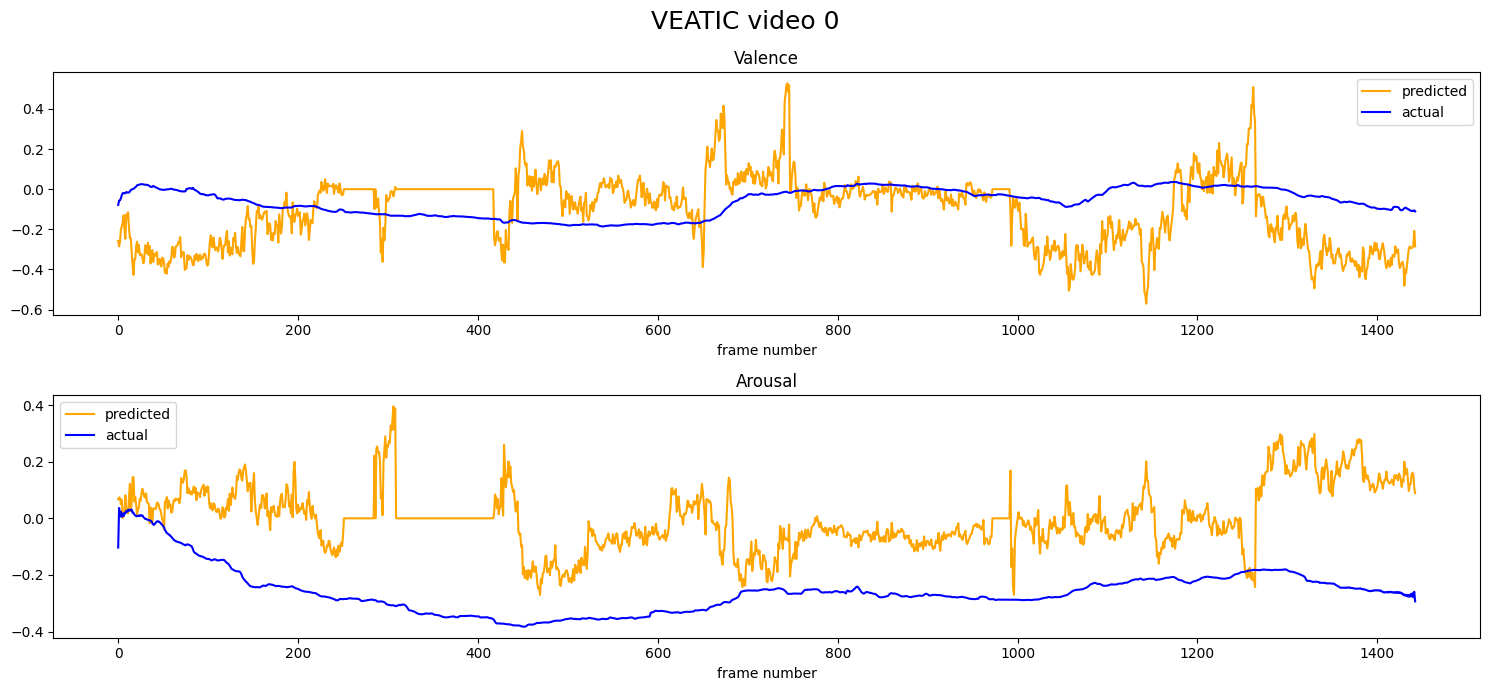

In [100]:
x_values = range(len(valence_pred))

print(x_values)

fig, ax = plt.subplots(nrows=2, figsize=(15,7))

fig.suptitle(f'VEATIC video {veatic_idx}', fontsize=18)

ax[0].set_title('Valence')
ax[0].plot(x_values, valence_pred, c='orange', label='predicted')
ax[0].plot(x_values, video.valence_values, c='blue', label='actual')
# diff = np.array(valence_pred) - np.array(video.valence_values)
# ax[0].plot(x_values, diff, label='diff')
ax[0].legend()
ax[0].set_xlabel("frame number")
# ax[0].set_ylabel("Valence")

ax[1].set_title('Arousal')
ax[1].plot(x_values, arousal_pred, c='orange', label='predicted')
ax[1].plot(x_values, video.arousal_values, c='blue', label='actual')
ax[1].legend()
ax[1].set_xlabel("frame number")
# ax[1].set_ylabel("Arousal")

fig.tight_layout()
plt.show()